In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install patchify
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab/dubai_dataset/data/Tile 7/images/image_part_001.jpg", 1)

#original_mask = cv2.imread("/content/drive/MyDrive/Colab/dubai_dataset/data/Tile 8/masks/image_part_002.png", 1)
#original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("/content/drive/MyDrive/Colab/dubai_dataset/Models/satellite_standard_unet_100epochs_9May2024.hdf5", compile=False)

# size of patches
patch_size = 256

# Number of classes
n_classes = 6

1/1 [==============================] - 0s 186ms/step


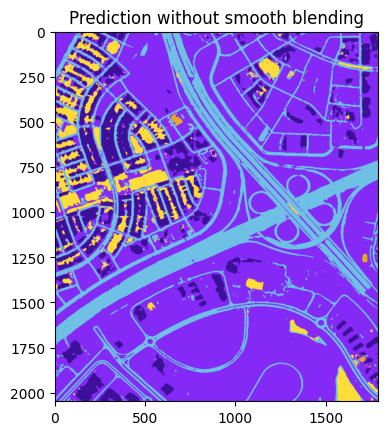

In [ ]:
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:,:]

        #Use minmaxscaler instead of just dividing by 255.
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]

        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1],
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

#plt.imshow(unpatched_prediction)

#plt.axis('off')

def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155



    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)

plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.savefig('/content/drive/MyDrive/Colab/dubai_dataset/Resuluts/Tile8_image2_resulut_unpatchified2.png')


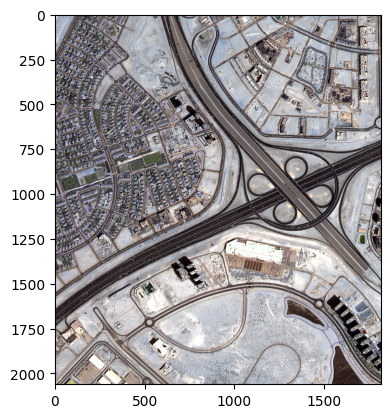

In [ ]:
plt.imshow(img)

In [ ]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.15.0
TensorFlow version: 2.15.0
